# W2V + BilSTM

In [1]:
import os, re, time, random, numpy as np, pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import gensim.downloader as api
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam


2025-11-06 16:24:41.890989: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 16:24:41.931421: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2025-11-06 16:24:47.269101: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
PATH = "dataset_EDA_completo.csv"
df = pd.read_csv(PATH)

df = df[['clean_text', 'category']].dropna()
df = df[df['clean_text'].str.strip().str.len() > 0].copy()

le = LabelEncoder()
df['y'] = le.fit_transform(df['category'])
num_classes = df['y'].nunique()

X_train, X_tmp, y_train, y_tmp = train_test_split(
    df['clean_text'], df['y'], test_size=0.30, random_state=SEED, stratify=df['y']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)} | Clases: {num_classes}")


FileNotFoundError: [Errno 2] No such file or directory: 'dataset_EDA_completo.csv'

In [37]:
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words("english"))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z']", " ", text.lower())
    tokens = word_tokenize(text)
    return [t for t in tokens if t not in STOPWORDS and len(t) > 2]

sentences = [clean_text(t) for t in df['clean_text']]
print("✅ Ejemplo de tokens:", sentences[0][:10])


✅ Ejemplo de tokens: ['accountant', 'summary', 'financial', 'accountant', 'specializing', 'financial', 'planning', 'reporting', 'analysis', 'within']


In [47]:
from gensim.models import KeyedVectors

print("🔹 Cargando modelo FastText (crawl-300d-2M-subword.vec)...")
path = "/home/nicoplayz/Deep Learning/LLM/Jarvis Calling Hiring Contest/crawl-300d-2M-subword.vec"

w2v_model = KeyedVectors.load_word2vec_format(path, binary=False)
EMB_DIM = 300
print(f"✅ Modelo cargado: {len(w2v_model.key_to_index)} palabras.")



🔹 Cargando modelo FastText (crawl-300d-2M-subword.vec)...
✅ Modelo cargado: 2000000 palabras.


In [48]:
embedding_matrix = np.zeros((vocab_size, EMB_DIM))
found = 0
for word, i in tokenizer.word_index.items():
    if word in w2v_model.key_to_index:
        embedding_matrix[i] = w2v_model[word]
        found += 1
print(f"✅ Palabras cubiertas: {found}/{vocab_size} ({found/vocab_size*100:.1f}%)")


✅ Palabras cubiertas: 27714/40647 (68.2%)


In [40]:
embedding_matrix = np.zeros((vocab_size, EMB_DIM))
found = 0

for word, i in tokenizer.word_index.items():
    if word in w2v_model.key_to_index:
        embedding_matrix[i] = w2v_model[word]
        found += 1

print(f"✅ Palabras con embeddings encontrados: {found}/{vocab_size}")



✅ Palabras con embeddings encontrados: 23324/40647


In [50]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dropout, Dense, BatchNormalization, SpatialDropout1D, LeakyReLU
from tensorflow.keras.optimizers import Adam

def build_bilstm(vocab_size, emb_dim, embedding_matrix, sequence_length, num_classes):
    model = Sequential([
        Embedding(vocab_size, emb_dim, weights=[embedding_matrix],
                  input_length=sequence_length, trainable=True),
        SpatialDropout1D(0.2),
        Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2)),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(64)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128),
        LeakyReLU(alpha=0.1),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=2e-4, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import time

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, min_lr=1e-6),
    ModelCheckpoint("best_bilstm_fasttext.h5", monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
]

t0 = time.time()
history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=50,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()
train_time_s = round(t1 - t0, 2)
print(f"⏱️ Tiempo total de entrenamiento: {train_time_s} segundos")


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 814ms/step - accuracy: 0.4992 - loss: 1.7426
Epoch 1: val_accuracy improved from None to 0.32353, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 891ms/step - accuracy: 0.5100 - loss: 1.7265 - val_accuracy: 0.3235 - val_loss: 2.3828 - learning_rate: 1.0000e-04
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.5188 - loss: 1.7088
Epoch 2: val_accuracy did not improve from 0.32353
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 863ms/step - accuracy: 0.5205 - loss: 1.7050 - val_accuracy: 0.3186 - val_loss: 2.3793 - learning_rate: 1.0000e-04
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.5126 - loss: 1.6800
Epoch 3: val_accuracy did not improve from 0.32353
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 873ms/step - accuracy: 0.5247 - loss: 1.6644 - val_accuracy: 0.3211 - val_loss: 2.3749 - learning_rate: 1.0000e-04
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 797ms/step - accuracy: 0.5421 - loss: 1.6511
Epoch 4: val_accuracy improved from 0.32353 to 0.32598, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 867ms/step - accuracy: 0.5431 - loss: 1.6369 - val_accuracy: 0.3260 - val_loss: 2.3723 - learning_rate: 1.0000e-04
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - accuracy: 0.5413 - loss: 1.6229
Epoch 5: val_accuracy improved from 0.32598 to 0.33824, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 818ms/step - accuracy: 0.5410 - loss: 1.6159 - val_accuracy: 0.3382 - val_loss: 2.3676 - learning_rate: 1.0000e-04
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.5277 - loss: 1.6188
Epoch 6: val_accuracy did not improve from 0.33824
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 816ms/step - accuracy: 0.5310 - loss: 1.6050 - val_accuracy: 0.3358 - val_loss: 2.3624 - learning_rate: 1.0000e-04
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 762ms/step - accuracy: 0.5443 - loss: 1.6296
Epoch 7: val_accuracy improved from 0.33824 to 0.34314, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 829ms/step - accuracy: 0.5515 - loss: 1.5947 - val_accuracy: 0.3431 - val_loss: 2.3548 - learning_rate: 1.0000e-04
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 774ms/step - accuracy: 0.5413 - loss: 1.6265
Epoch 8: val_accuracy improved from 0.34314 to 0.34559, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 848ms/step - accuracy: 0.5446 - loss: 1.5930 - val_accuracy: 0.3456 - val_loss: 2.3500 - learning_rate: 1.0000e-04
Epoch 9/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 773ms/step - accuracy: 0.5479 - loss: 1.5832
Epoch 9: val_accuracy did not improve from 0.34559
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 833ms/step - accuracy: 0.5604 - loss: 1.5621 - val_accuracy: 0.3407 - val_loss: 2.3478 - learning_rate: 1.0000e-04
Epoch 10/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.5826 - loss: 1.5351
Epoch 10: val_accuracy did not improve from 0.34559
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 894ms/step - accuracy: 0.5772 - loss: 1.5233 - val_accuracy: 0.3456 - val_loss: 2.3455 - learning_rate: 1.0000e-04
Epoch 11/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 785ms/step - accuracy: 0.5930 - loss: 1.5175
Epoch 11: val_accuracy improved from 0.34559 to 0.34804, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 858ms/step - accuracy: 0.5840 - loss: 1.5143 - val_accuracy: 0.3480 - val_loss: 2.3395 - learning_rate: 1.0000e-04
Epoch 12/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 761ms/step - accuracy: 0.5706 - loss: 1.5085
Epoch 12: val_accuracy did not improve from 0.34804
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 820ms/step - accuracy: 0.5856 - loss: 1.4921 - val_accuracy: 0.3480 - val_loss: 2.3392 - learning_rate: 1.0000e-04
Epoch 13/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 837ms/step - accuracy: 0.5816 - loss: 1.4845
Epoch 13: val_accuracy did not improve from 0.34804
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 898ms/step - accuracy: 0.5935 - loss: 1.4578 - val_accuracy: 0.3456 - val_loss: 2.3385 - learning_rate: 1.0000e-04
Epoch 14/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.5743 - loss: 1.4907
Epoch 14: val_accuracy did not improve from 0.34804
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 836ms/step - accuracy: 0.5804 - loss: 1.4713 - val_accuracy: 0.3431 - val_loss: 2.3330 - learning_rate: 1.0000e-04

15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 846ms/step - accuracy: 0.5998 - loss: 1.4326 - val_accuracy: 0.3505 - val_loss: 2.3241 - learning_rate: 1.0000e-04
Epoch 17/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 752ms/step - accuracy: 0.6018 - loss: 1.4057
Epoch 17: val_accuracy did not improve from 0.35049
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 815ms/step - accuracy: 0.6071 - loss: 1.3951 - val_accuracy: 0.3505 - val_loss: 2.3224 - learning_rate: 1.0000e-04
Epoch 18/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 806ms/step - accuracy: 0.6005 - loss: 1.4082
Epoch 18: val_accuracy improved from 0.35049 to 0.35294, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 878ms/step - accuracy: 0.6134 - loss: 1.3996 - val_accuracy: 0.3529 - val_loss: 2.3230 - learning_rate: 1.0000e-04
Epoch 19/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 753ms/step - accuracy: 0.6127 - loss: 1.3746
Epoch 19: val_accuracy did not improve from 0.35294
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 817ms/step - accuracy: 0.6234 - loss: 1.3636 - val_accuracy: 0.3529 - val_loss: 2.3288 - learning_rate: 1.0000e-04
Epoch 20/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 758ms/step - accuracy: 0.6097 - loss: 1.3595
Epoch 20: val_accuracy improved from 0.35294 to 0.36029, saving model to best_bilstm_fasttext.h5


15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 827ms/step - accuracy: 0.6218 - loss: 1.3544 - val_accuracy: 0.3603 - val_loss: 2.3254 - learning_rate: 1.0000e-04
Epoch 21/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 733ms/step - accuracy: 0.6266 - loss: 1.3608
Epoch 21: val_accuracy did not improve from 0.36029
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 792ms/step - accuracy: 0.6297 - loss: 1.3499 - val_accuracy: 0.3554 - val_loss: 2.3241 - learning_rate: 5.0000e-05
Epoch 22/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 775ms/step - accuracy: 0.6231 - loss: 1.3493
Epoch 22: val_accuracy did not improve from 0.36029
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 831ms/step - accuracy: 0.6308 - loss: 1.3249 - val_accuracy: 0.3578 - val_loss: 2.3213 - learning_rate: 5.0000e-05
Epoch 23/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 731ms/step - accuracy: 0.6180 - loss: 1.3307
Epoch 23: val_accuracy did not improve from 0.36029
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 789ms/step - accuracy: 0.6313 - loss: 1.3176 - val_accuracy: 0.3603 - val_loss: 2.3188 - learning_rate: 5.0000e-05

15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 809ms/step - accuracy: 0.6392 - loss: 1.3110 - val_accuracy: 0.3627 - val_loss: 2.3158 - learning_rate: 5.0000e-05
Epoch 26/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 713ms/step - accuracy: 0.6295 - loss: 1.3445
Epoch 26: val_accuracy did not improve from 0.36275
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 768ms/step - accuracy: 0.6381 - loss: 1.3081 - val_accuracy: 0.3627 - val_loss: 2.3138 - learning_rate: 5.0000e-05
Epoch 27/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 709ms/step - accuracy: 0.6499 - loss: 1.2938
Epoch 27: val_accuracy did not improve from 0.36275
15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 765ms/step - accuracy: 0.6497 - loss: 1.2795 - val_accuracy: 0.3554 - val_loss: 2.3128 - learning_rate: 5.0000e-05
Epoch 28/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 746ms/step - accuracy: 0.6414 - loss: 1.3016
Epoch 28: val_accuracy did not improve from 0.36275
15/15 ━━━━━━━━━━━━━━━━━━━━ 12s 810ms/step - accuracy: 0.6413 - loss: 1.2795 - val_accuracy: 0.3578 - val_loss: 2.3135 - learning_rate: 5.0000e-05

In [53]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import numpy as np
import time

# 🔹 Evaluación
t_eval_0 = time.time()
y_pred_proba = model.predict(X_test_pad, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
t_eval_1 = time.time()

# 🔹 Métricas clásicas
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

# 🔹 ROC-AUC One-vs-Rest
try:
    # Para multiclase se necesita probas (no etiquetas)
    roc_auc = roc_auc_score(
        y_test, y_pred_proba, multi_class='ovr', average='macro'
    )
except Exception as e:
    roc_auc = np.nan
    print(f"⚠️ No se pudo calcular ROC-AUC: {e}")

# 🔹 Mostrar resumen
print("\n📈 Resultados finales:")
print(f"   Accuracy:          {accuracy:.4f}")
print(f"   Precision (Macro): {precision:.4f}")
print(f"   Recall (Macro):    {recall:.4f}")
print(f"   F1-Score (Macro):  {f1:.4f}")
print(f"   ROC-AUC (OvR):     {roc_auc:.4f}")
print(f"   Tiempo entrenamiento: {train_time_s:.2f} s")
print(f"   Tiempo evaluación:   {t_eval_1 - t_eval_0:.2f} s")

# 🔹 Guardar en DataFrame
df_metrics = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision (Macro)": precision,
    "Recall (Macro)": recall,
    "F1-Score (Macro)": f1,
    "Train Time (s)": train_time_s,
    "ROC-AUC (OvR)": roc_auc
}])

display(df_metrics)

13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step

📈 Resultados finales:
   Accuracy:          0.3652
   Precision (Macro): 0.3451
   Recall (Macro):    0.3612
   F1-Score (Macro):  0.3469
   ROC-AUC (OvR):     0.8190
   Tiempo entrenamiento: 374.85 s
   Tiempo evaluación:   2.94 s


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),Train Time (s),ROC-AUC (OvR)
0,0.365196,0.345104,0.361165,0.346888,374.85,0.818993


In [54]:
# 🔹 Guardar CSV en el proyecto
df_metrics.to_csv("resultados_bilstm_fasttext.csv", index=False)
print("\n💾 Resultados guardados en 'resultados_bilstm_fasttext.csv'")


💾 Resultados guardados en 'resultados_bilstm_fasttext.csv'


# CNN-1D con Embeddings

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding, Conv1D, GlobalMaxPooling1D,
    Dropout, Dense, BatchNormalization
)
from tensorflow.keras.optimizers import Adam

def build_cnn1d(vocab_size, emb_dim, embedding_matrix, sequence_length, num_classes):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=emb_dim,
            weights=[embedding_matrix],
            input_length=sequence_length,
            trainable=False  # usamos FastText fijo
        ),
        Conv1D(256, 5, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),

        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        GlobalMaxPooling1D(),

        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time

cnn_model = build_cnn1d(vocab_size, EMB_DIM, embedding_matrix, MAX_LEN, num_classes)

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(patience=3, factor=0.5, monitor='val_loss', min_lr=1e-5)
]

t0 = time.time()
history_cnn = cnn_model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=40,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)
t1 = time.time()
train_time_cnn = round(t1 - t0, 2)
print(f"⏱️ Tiempo total de entrenamiento: {train_time_cnn} segundos")


Epoch 1/40


/home/nicoplayz/tf312/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-06 15:04:32.998861: I external/local_xla/xla/service/service.cc:153] XLA service 0x7e32580086a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-06 15:04:32.999707: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Laptop GPU, Compute Capability 12.0
2025-11-06 15:04:33.110136: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-06 15:04:33.467191: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this 

16/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0350 - loss: 7.5023 

I0000 00:00:1762459478.315882  214569 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-11-06 15:04:38.582137: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:04:38.582176: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:04:38.582184: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.0365 - loss: 7.0951

2025-11-06 15:04:42.274413: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:04:42.764589: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 84 bytes spill stores, 84 bytes spill loads

2025-11-06 15:04:42.775313: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 120 bytes spill stores, 120 bytes spill loads

2025-11-06 15:04:42.847357: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_114', 92 byte

30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 248ms/step - accuracy: 0.0410 - loss: 6.3958 - val_accuracy: 0.0588 - val_loss: 3.1757 - learning_rate: 1.0000e-04
Epoch 2/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0588 - loss: 4.7977 - val_accuracy: 0.0441 - val_loss: 3.1762 - learning_rate: 1.0000e-04
Epoch 3/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0867 - loss: 3.9411 - val_accuracy: 0.0613 - val_loss: 3.1765 - learning_rate: 1.0000e-04
Epoch 4/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.0982 - loss: 3.4923 - val_accuracy: 0.0637 - val_loss: 3.1739 - learning_rate: 1.0000e-04
Epoch 5/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1229 - loss: 3.2104 - val_accuracy: 0.0784 - val_loss: 3.1676 - learning_rate: 1.0000e-04
Epoch 6/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1586 - loss: 2.9814 - val_accuracy: 0.0858 - val_loss: 3.1562 - learning_rate: 1.0000e-04
Epoch 7/40
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.1843 - loss: 2.8366 

In [57]:
# ======================================================
# 🔍 Evaluación del modelo CNN-1D
# ======================================================
t_eval_0 = time.time()
y_pred_proba = cnn_model.predict(X_test_pad, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
t_eval_1 = time.time()

# ======================================================
# 📏 Métricas de desempeño
# ======================================================
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

try:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
except Exception as e:
    roc_auc = np.nan
    print(f"⚠️ No se pudo calcular ROC-AUC: {e}")

# ======================================================
# 📈 Resultados finales
# ======================================================
print("\n📊 Resultados finales CNN-1D:")
print(f"   Accuracy:          {accuracy:.4f}")
print(f"   Precision (Macro): {precision:.4f}")
print(f"   Recall (Macro):    {recall:.4f}")
print(f"   F1-Score (Macro):  {f1:.4f}")
print(f"   ROC-AUC (OvR):     {roc_auc:.4f}")
print(f"   Tiempo entrenamiento: {train_time_cnn:.2f} s")
print(f"   Tiempo evaluación:   {t_eval_1 - t_eval_0:.2f} s")

# ======================================================
# 💾 Guardar resultados
# ======================================================
df_metrics_cnn = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision (Macro)": precision,
    "Recall (Macro)": recall,
    "F1-Score (Macro)": f1,
    "Train Time (s)": train_time_cnn,
    "ROC-AUC (OvR)": roc_auc
}])

display(df_metrics_cnn)

2025-11-06 15:05:25.090758: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:05:25.090798: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:05:25.625818: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 80 bytes spill stores, 80 bytes spill loads

2025-11-06 15:05:25.716468: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step

📊 Resultados finales CNN-1D:
   Accuracy:          0.3676
   Precision (Macro): 0.3681
   Recall (Macro):    0.3639
   F1-Score (Macro):  0.3604
   ROC-AUC (OvR):     0.8379
   Tiempo entrenamiento: 20.39 s
   Tiempo evaluación:   1.96 s


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),Train Time (s),ROC-AUC (OvR)
0,0.367647,0.368105,0.363933,0.360398,20.39,0.837887


In [58]:
df_metrics_cnn.to_csv("resultados_cnn1d_fasttext.csv", index=False)
print("\n💾 Resultados guardados en 'resultados_cnn1d_fasttext.csv'")


💾 Resultados guardados en 'resultados_cnn1d_fasttext.csv'


# TF-IDF + XGBoost con GPU

In [1]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

In [2]:
SEED = 42
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
STOPWORDS = set(stopwords.words("english"))

# ===========================================================
# 🧹 Cargar y limpiar texto
# ===========================================================
PATH = "dataset_EDA_completo.csv"
df = pd.read_csv(PATH)

df = df[['clean_text', 'category']].dropna()
df['clean_text'] = df['clean_text'].apply(lambda x: " ".join(x) if isinstance(x, list) else str(x))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z']", " ", text.lower())
    tokens = word_tokenize(text)
    tokens = [t for t in tokens if t not in STOPWORDS and len(t) > 2]
    return " ".join(tokens)

df['clean_text'] = df['clean_text'].apply(clean_text)
df = df[df['clean_text'].str.strip().str.len() > 0].reset_index(drop=True)

# ===========================================================
# 🏷️ Codificar etiquetas
# ===========================================================
le = LabelEncoder()
df['y'] = le.fit_transform(df['category'])
num_classes = df['y'].nunique()

# ===========================================================
# ✂️ Split datasets
# ===========================================================
X_train, X_tmp, y_train, y_tmp = train_test_split(
    df['clean_text'], df['y'], test_size=0.30, random_state=SEED, stratify=df['y']
)
X_val, X_test, y_val, y_test = train_test_split(
    X_tmp, y_tmp, test_size=0.50, random_state=SEED, stratify=y_tmp
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)} | Clases: {num_classes}")

Train: 1904 | Val: 408 | Test: 408 | Clases: 24


In [3]:
# ===========================================================
# 🔤 TF-IDF
# ===========================================================
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2), sublinear_tf=True)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf   = vectorizer.transform(X_val)
X_test_tfidf  = vectorizer.transform(X_test)


In [15]:
import time
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import numpy as np

# ===========================================================
# ⚙️ Entrenamiento con temporizador
# ===========================================================
t_train_0 = time.time()

model = XGBClassifier(
    objective="multi:softprob",   # importante
    num_class=num_classes,
    eval_metric="mlogloss",
    tree_method="hist",
    device="cuda",
    random_state=SEED,
    learning_rate=0.1,
    n_estimators=300,
    max_depth=6
)
model.fit(
    X_train_tfidf, y_train,
    eval_set=[(X_val_tfidf, y_val)],
    verbose=True
)

t_train_1 = time.time()
train_time_s = t_train_1 - t_train_0

print(f"\n⏱️ Tiempo total de entrenamiento: {train_time_s:.2f} s")

[0]	validation_0-mlogloss:2.68413
[1]	validation_0-mlogloss:2.36311
[2]	validation_0-mlogloss:2.74673
[3]	validation_0-mlogloss:3.16538
[4]	validation_0-mlogloss:3.76375
[5]	validation_0-mlogloss:4.00142
[6]	validation_0-mlogloss:4.24540
[7]	validation_0-mlogloss:4.39064
[8]	validation_0-mlogloss:4.75565
[9]	validation_0-mlogloss:5.19918
[10]	validation_0-mlogloss:5.65568
[11]	validation_0-mlogloss:6.21327
[12]	validation_0-mlogloss:6.72532
[13]	validation_0-mlogloss:7.43753
[14]	validation_0-mlogloss:7.83652
[15]	validation_0-mlogloss:7.98482
[16]	validation_0-mlogloss:8.12469
[17]	validation_0-mlogloss:8.35824
[18]	validation_0-mlogloss:8.54252
[19]	validation_0-mlogloss:8.39802
[20]	validation_0-mlogloss:8.75452
[21]	validation_0-mlogloss:8.77872
[22]	validation_0-mlogloss:9.15248
[23]	validation_0-mlogloss:9.46680
[24]	validation_0-mlogloss:9.83586
[25]	validation_0-mlogloss:9.93657
[26]	validation_0-mlogloss:10.15471
[27]	validation_0-mlogloss:10.38542
[28]	validation_0-mlogloss:1

In [16]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
)
import pandas as pd
import numpy as np
import time

# ===========================================================
# 🕒 Evaluación
# ===========================================================
t_eval_0 = time.time()

# Predicciones de probabilidad (solo disponible con 'multi:softprob')
y_pred_proba = model.predict_proba(X_test_tfidf)
print("y_pred_proba shape:", y_pred_proba.shape)

# 🔹 Si el modelo devuelve vector 1D, forzamos matriz one-hot
if y_pred_proba.ndim == 1:
    from sklearn.preprocessing import label_binarize
    y_pred_proba = label_binarize(y_pred_proba.astype(int),
                                  classes=np.arange(num_classes))
    print("⚠️ XGBoost devolvió vector 1D, convertido a matriz:", y_pred_proba.shape)

# 🔹 Etiquetas finales
y_pred = np.argmax(y_pred_proba, axis=1)

t_eval_1 = time.time()

# ===========================================================
# 📊 Métricas clásicas
# ===========================================================
accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)

# ===========================================================
# 💫 ROC-AUC (solo si tienes probabilidades)
# ===========================================================
try:
    roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
except Exception as e:
    roc_auc = np.nan
    print(f"⚠️ No se pudo calcular ROC-AUC: {e}")

# ===========================================================
# 🧮 Mostrar resumen bonito
# ===========================================================
print("\n📈 Resultados finales:")
print(f"   Accuracy:          {accuracy:.4f}")
print(f"   Precision (Macro): {precision:.4f}")
print(f"   Recall (Macro):    {recall:.4f}")
print(f"   F1-Score (Macro):  {f1:.4f}")
print(f"   ROC-AUC (OvR):     {roc_auc:.4f}")
print(f"   Tiempo entrenamiento: {train_time_s:.2f} s")
print(f"   Tiempo evaluación:   {t_eval_1 - t_eval_0:.2f} s")

# ===========================================================
# 📊 Guardar en DataFrame (para tabla resumen)
# ===========================================================
df_metrics = pd.DataFrame([{
    "Accuracy": accuracy,
    "Precision (Macro)": precision,
    "Recall (Macro)": recall,
    "F1-Score (Macro)": f1,
    "ROC-AUC (OvR)": roc_auc,
    "Train Time (s)": train_time_s,
    "Eval Time (s)": t_eval_1 - t_eval_0
}])

display(df_metrics)


y_pred_proba shape: (408, 24)

📈 Resultados finales:
   Accuracy:          0.4510
   Precision (Macro): 0.4947
   Recall (Macro):    0.4470
   F1-Score (Macro):  0.4106
   ROC-AUC (OvR):     0.8521
   Tiempo entrenamiento: 20.55 s
   Tiempo evaluación:   0.20 s


,Accuracy,Precision (Macro),Recall (Macro),F1-Score (Macro),ROC-AUC (OvR),Train Time (s),Eval Time (s)
0,0.45098,0.494732,0.447008,0.410594,0.852114,20.551007,0.19954


/tmp/ipykernel_279001/1999606607.py:24: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/nicoplayz/tf312/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


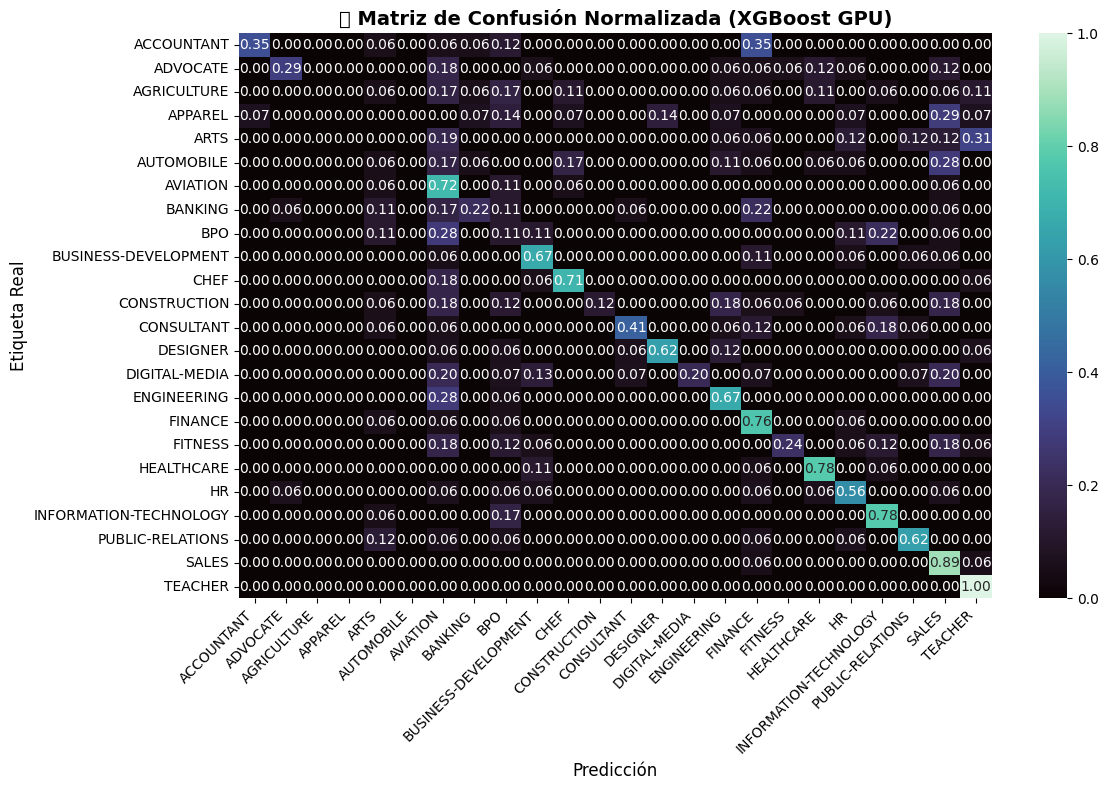

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ===========================================================
# 🎨 Heatmap de matriz de confusión
# ===========================================================
cm = confusion_matrix(y_test, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 8))
sns.heatmap(cm_normalized,
            annot=True,
            fmt=".2f",
            cmap="mako",
            xticklabels=le.classes_,
            yticklabels=le.classes_)

plt.title("🔍 Matriz de Confusión Normalizada (XGBoost GPU)", fontsize=14, fontweight="bold")
plt.xlabel("Predicción", fontsize=12)
plt.ylabel("Etiqueta Real", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
from datetime import datetime

# ===========================================================
# 💾 Guardar resultados en CSV con timestamp
# ===========================================================
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"metrics_xgboost_{timestamp}.csv"

df_metrics.to_csv(filename, index=False, encoding='utf-8-sig')
print(f"✅ Resultados guardados en: {filename}")


✅ Resultados guardados en: metrics_xgboost_2025-11-06_15-34-53.csv


# FAST TEXT con entrenamiento local

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

# Tokenización
MAX_WORDS = 10000
MAX_LEN = 200

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post', truncating='post')

# One-hot de etiquetas
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat   = to_categorical(y_val, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)


2025-11-06 15:39:29.651401: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-06 15:39:30.340415: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-06 15:39:32.856302: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense

def build_fasttext_model():
    model = Sequential([
        Embedding(input_dim=MAX_WORDS, output_dim=100, input_length=MAX_LEN),
        GlobalAveragePooling1D(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


In [21]:
import tensorflow as tf, time

# Forzar CPU
with tf.device('/CPU:0'):
    model_cpu = build_fasttext_model()
    t0 = time.time()
    history_cpu = model_cpu.fit(
        X_train_pad, y_train_cat,
        validation_data=(X_val_pad, y_val_cat),
        epochs=10,
        batch_size=64,
        verbose=1
    )
    t1 = time.time()

train_time_cpu = t1 - t0
print(f"✅ Entrenamiento CPU completado en {train_time_cpu:.2f} s")


Epoch 1/10


I0000 00:00:1762461589.734244  279001 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5078 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 5070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 12.0
/home/nicoplayz/tf312/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-11-06 15:39:50.988920: I external/local_xla/xla/service/service.cc:153] XLA service 0x748e0400a680 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2025-11-06 15:39:50.988940: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): Host, Default Version
2025-11-06 15:39:51.045008: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0894 - loss: 3.1754

I0000 00:00:1762461591.496705  279306 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1807 - loss: 3.1653 - val_accuracy: 0.2868 - val_loss: 3.1411
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3750 - loss: 3.0739 - val_accuracy: 0.3407 - val_loss: 3.0038
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4322 - loss: 2.8122 - val_accuracy: 0.3652 - val_loss: 2.7053
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5084 - loss: 2.3778 - val_accuracy: 0.4755 - val_loss: 2.3141
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6056 - loss: 1.9269 - val_accuracy: 0.5172 - val_loss: 1.9855
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6712 - loss: 1.5767 - val_accuracy: 0.5588 - val_loss: 1.7792
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7264 - loss: 1.3168 - val_accuracy: 0.5613 - val_loss: 1.6316
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7558 - loss: 1.1177 - val_accuracy: 0.5980 - val_loss: 1.5203
Ep

In [22]:
# Verificar GPU disponible
print("Dispositivos disponibles:", tf.config.list_physical_devices('GPU'))

# Entrenamiento en GPU
with tf.device('/GPU:0'):
    model_gpu = build_fasttext_model()
    t0 = time.time()
    history_gpu = model_gpu.fit(
        X_train_pad, y_train_cat,
        validation_data=(X_val_pad, y_val_cat),
        epochs=10,
        batch_size=64,
        verbose=1
    )
    t1 = time.time()

train_time_gpu = t1 - t0
print(f"✅ Entrenamiento GPU completado en {train_time_gpu:.2f} s")


Dispositivos disponibles: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Epoch 1/10


2025-11-06 15:40:02.048308: I external/local_xla/xla/service/service.cc:153] XLA service 0x748e04dd5650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-06 15:40:02.048331: I external/local_xla/xla/service/service.cc:161]   StreamExecutor device (0): NVIDIA GeForce RTX 5070 Laptop GPU, Compute Capability 12.0
I0000 00:00:1762461602.168842  279306 cuda_dnn.cc:530] Loaded cuDNN version 90800
2025-11-06 15:40:02.199229: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:02.199264: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative 

 1/30 ━━━━━━━━━━━━━━━━━━━━ 2:02 4s/step - accuracy: 0.0156 - loss: 3.1780

2025-11-06 15:40:05.917143: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:05.917185: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:05.917191: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:05.917197: W external/loca

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0975 - loss: 3.1727

2025-11-06 15:40:09.255639: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:09.255680: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:40:09.910754: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_95', 80 bytes spill stores, 80 bytes spill loads

2025-11-06 15:40:09.959127: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg

30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 192ms/step - accuracy: 0.1408 - loss: 3.1658 - val_accuracy: 0.2990 - val_loss: 3.1425
Epoch 2/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4391 - loss: 3.0820 - val_accuracy: 0.4093 - val_loss: 3.0201
Epoch 3/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5173 - loss: 2.8442 - val_accuracy: 0.4583 - val_loss: 2.7292
Epoch 4/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5441 - loss: 2.3958 - val_accuracy: 0.5049 - val_loss: 2.2951
Epoch 5/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5998 - loss: 1.9114 - val_accuracy: 0.5392 - val_loss: 1.9567
Epoch 6/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6717 - loss: 1.5570 - val_accuracy: 0.5613 - val_loss: 1.7589
Epoch 7/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7143 - loss: 1.3095 - val_accuracy: 0.5858 - val_loss: 1.6151
Epoch 8/10
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7605 - loss: 1.1083 - val_accuracy: 0.6005 - val_loss: 1.5119


In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluar_modelo(model, X_test_pad, y_test, y_test_cat, nombre, train_time):
    import pandas as pd, numpy as np, time

    t0 = time.time()
    y_pred_proba = model.predict(X_test_pad, verbose=0)
    y_pred = np.argmax(y_pred_proba, axis=1)
    t1 = time.time()

    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall    = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1        = f1_score(y_test, y_pred, average='macro', zero_division=0)
    roc_auc   = roc_auc_score(y_test_cat, y_pred_proba, multi_class='ovr', average='macro')

    print(f"\n📈 {nombre}:")
    print(f"   Accuracy:  {accuracy:.4f}")
    print(f"   Precision: {precision:.4f}")
    print(f"   Recall:    {recall:.4f}")
    print(f"   F1:        {f1:.4f}")
    print(f"   ROC-AUC:   {roc_auc:.4f}")
    print(f"   Tiempo entrenamiento: {train_time:.2f} s")
    print(f"   Tiempo evaluación:   {t1 - t0:.2f} s")

    return pd.DataFrame([{
        "Modelo": nombre,
        "Accuracy": accuracy,
        "Precision (Macro)": precision,
        "Recall (Macro)": recall,
        "F1-Score (Macro)": f1,
        "ROC-AUC (OvR)": roc_auc,
        "Train Time (s)": train_time,
        "Eval Time (s)": t1 - t0
    }])


In [28]:
# ======================================================
# 🧠 Evaluar modelo CPU
# ======================================================
with tf.device('/CPU:0'):
    print("⚙️ Evaluando modelo CPU...")
    df_cpu = evaluar_modelo(
        model_cpu,
        X_test_pad,
        y_test,
        y_test_cat,
        "FastText CPU (preentrenado)",
        train_time_cpu
    )

# ======================================================
# ⚡ Evaluar modelo GPU
# ======================================================
with tf.device('/GPU:0'):
    print("⚙️ Evaluando modelo GPU...")
    df_gpu = evaluar_modelo(
        model_gpu,
        X_test_pad,
        y_test,
        y_test_cat,
        "FastText GPU (preentrenado)",
        train_time_gpu
    )


⚙️ Evaluando modelo CPU...

📈 FastText CPU (preentrenado):
   Accuracy:  0.6078
   Precision: 0.6154
   Recall:    0.6022
   F1:        0.5983
   ROC-AUC:   0.9308
   Tiempo entrenamiento: 4.12 s
   Tiempo evaluación:   0.06 s
⚙️ Evaluando modelo GPU...


2025-11-06 15:45:06.766570: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:45:06.766606: W external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-11-06 15:45:07.185708: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_31', 12 bytes spill stores, 12 bytes spill loads

2025-11-06 15:45:07.284094: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Reg


📈 FastText GPU (preentrenado):
   Accuracy:  0.5931
   Precision: 0.6202
   Recall:    0.5902
   F1:        0.5971
   ROC-AUC:   0.9295
   Tiempo entrenamiento: 11.04 s
   Tiempo evaluación:   1.54 s


In [29]:
df_cpu.to_csv("metrics_fasttext_CPU.csv", index=False, encoding='utf-8-sig')
print("✅ Resultados CPU guardados en: metrics_fasttext_CPU.csv")

df_gpu.to_csv("metrics_fasttext_GPU.csv", index=False, encoding='utf-8-sig')
print("✅ Resultados GPU guardados en: metrics_fasttext_GPU.csv")


✅ Resultados CPU guardados en: metrics_fasttext_CPU.csv
✅ Resultados GPU guardados en: metrics_fasttext_GPU.csv
